In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import json
from glob import glob
from google.colab import drive
from matplotlib import pyplot as plt
from tensorflow.keras.applications import vgg16
from random import shuffle

In [2]:
TRAIN_PREFIX = '/content/drive/MyDrive/Colab Notebooks/Data_new/train'

def load_annotations():
    boxes = dict()
    for path in glob('/content/drive/MyDrive/Colab Notebooks/Data_new/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                if label == 'nof':
                  annotation['filename'] = os.path.join(TRAIN_PREFIX, 'NoF', basename)
                else:
                  annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        
            if 'cls' in rect:
              cls = np.argmax(rect['cls'])
              cv2.putText(img,
                          Index_to_class[cls] + ' %.3f' % rect['cls'][cls],
                          (pt1[0], pt1[1] - 5),
                          cv2.FONT_HERSHEY_SIMPLEX,
                          2, 
                          color,
                          2)
        
        
        
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

In [3]:
boxes = load_annotations()

Class_to_index = {k: i for i, k in enumerate(sorted(boxes.keys()))}
Index_to_class = {i: k for k, i in Class_to_index.items()}

pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

class  count
0    yft    734
1    bet    200
2    alb   1719
3    nof    465
4  other    299
5    lag     67
6  shark    176
7    dol    117

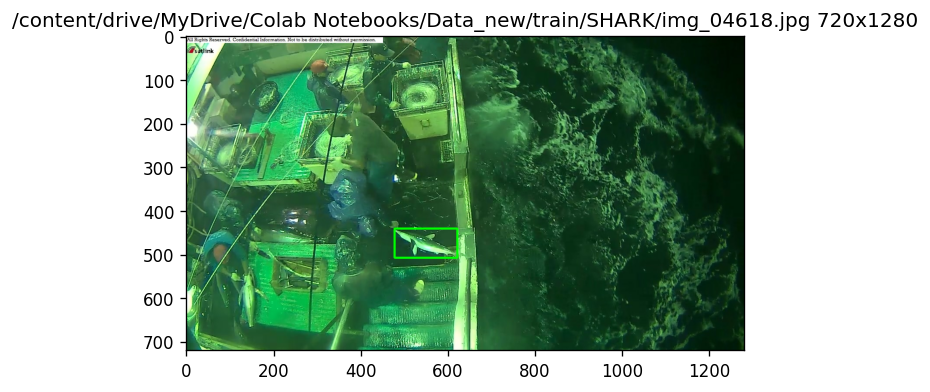

In [4]:
annotation = boxes['shark'][78]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

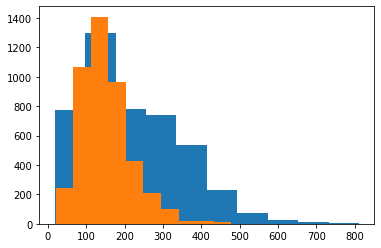

In [5]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

In [6]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

58892288/58889256 [==============================] - 2s 0us/step
(None, 23, 37, 512)


In [7]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

ANCHOR_CENTERS.shape

(2, 23, 37)

In [8]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, cls, qty_classes, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 
                              5 + qty_classes), dtype=np.float32)
    
    cls_one_hot = tf.keras.utils.to_categorical(cls, qty_classes).tolist()

    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh] + cls_one_hot
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col, :5]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]

                cls_logit = prediction[row,col, 5:]
                cls_softmax = np.exp(cls_logit) / np.sum(np.exp(cls_logit))

                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'cls': cls_softmax})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

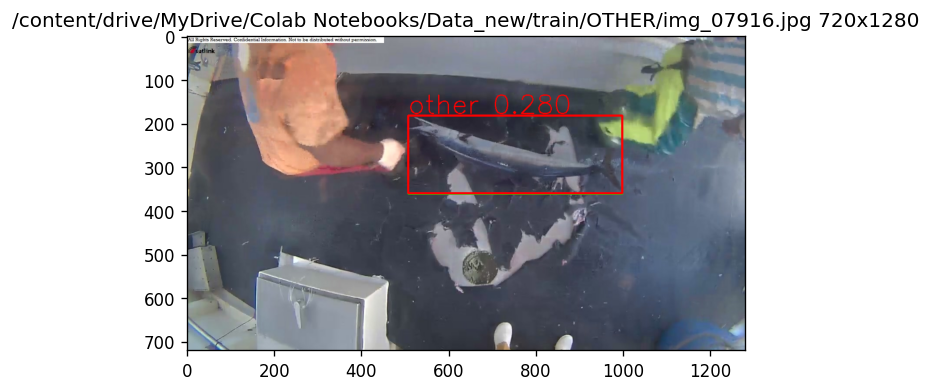

In [9]:
#annotation = boxes['shark'][1]
annotation = boxes['other'][2]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         cls = Class_to_index['other'],
                         qty_classes = len(Class_to_index),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

In [10]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def class_loss(y_true, y_pred):
    return K.categorical_crossentropy(y_true[..., 5:], 
                                      y_pred[..., 5:],
                                      from_logits=True)


def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:5] - y_pred[..., 1:5])
    square_loss = 0.5 * K.square(y_true[..., 1:5] - y_pred[..., 1:5])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
           
    y_true = K.reshape(y_true, (batch_size, -1, 5 + len(Class_to_index)))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5 + len(Class_to_index)))
    
    conf_loss = confidence_loss(y_true, y_pred)
    
    cls_loss = class_loss(y_true, y_pred)

    loc_loss = smooth_l1(y_true, y_pred)
    
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_cls_loss = K.sum(cls_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    cls_loss = pos_cls_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss + 0.25 * cls_loss

In [11]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum([[(k, box) for box in v] for k, v in boxes.items()], [])
    #boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                cls, box = boxes[j]
                img_shape, img = load_img(box['filename'])
                y.append(encode_anchors(box, img_shape,
                                        Class_to_index[cls], len(Class_to_index)))
                X.append(img)
            yield np.array(X), np.array(y)

In [12]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

output = tf.keras.layers.Conv2D(5 + len(Class_to_index),
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)     0     

In [13]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss, class_loss])

In [ ]:
%%time

batch_size = 16

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/Data_new/My_model_1.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=100)



model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10
100/236 [===========>..................] - ETA: 19:35 - loss: 2.5419 - confidence_loss: 0.7180 - class_loss: 0.0049
Epoch 00001: loss improved from inf to 1.67058, saving model to /content/drive/MyDrive/Colab Notebooks/Data_new/My_model_1.hdf5
200/236 [========================>.....] - ETA: 5:09 - loss: 2.0169 - confidence_loss: 0.6308 - class_loss: 0.0043
Epoch 00001: loss improved from 1.67058 to 1.36819, saving model to /content/drive/MyDrive/Colab Notebooks/Data_new/My_model_1.hdf5
236/236 [==============================] - 2114s 9s/step - loss: 1.9075 - confidence_loss: 0.6067 - class_loss: 0.0042
Epoch 2/10
 63/236 [=======>......................] - ETA: 8:53 - loss: 0.8992 - confidence_loss: 0.2912 - class_loss: 0.0023
Epoch 00002: loss improved from 1.36819 to 0.88013, saving model to /content/drive/MyDrive/Colab Notebooks/Data_new/My_model_1.hdf5
163/236 [===================>..........] - ETA: 3:45 - loss: 0.8726 - confidence_loss: 0.2763 - class_loss: 0.0021
Epoch 

In [14]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Data_new/My_model_1.hdf5')

In [15]:
str_nof = ["0.0", "0.0", "0.0", "0.0", "1.0", "0.0", "0.0", "0.0"] 

def show_detect_res(annotations, model, conf_thr=0.2, max_output_size=5):
  print('ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT\n')
    
  plt.figure(figsize=(6, 4 * len(annotations)), dpi=120)

  for i, annotation in enumerate(annotations, 1):
    _, sample_img = load_img(annotation['filename'])
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.25)
    decoded = non_max_suppression(decoded,
                                  max_output_size=5,
                                  iou_threshold=0.1)
    
    if len(decoded) == 0:
        print(f"{','.join(str_nof)}\n")
    else:
        print(f"{str(list(np.round(decoded[0]['cls'], 3)))[1:-1]}\n")

    img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))

    plt.subplot(len(annotation), 1, i)
    plt.imshow(img)
    plt.title('Предсказание модели: {}'.format('/'.join(annotation['filename'].split('/')[-3:])))
    print(' ')
  plt.show()

ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT

0.051, 0.0, 0.001, 0.0, 0.0, 0.001, 0.947, 0.0

 
0.0, 0.003, 0.001, 0.006, 0.0, 0.001, 0.983, 0.005

 
0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

 


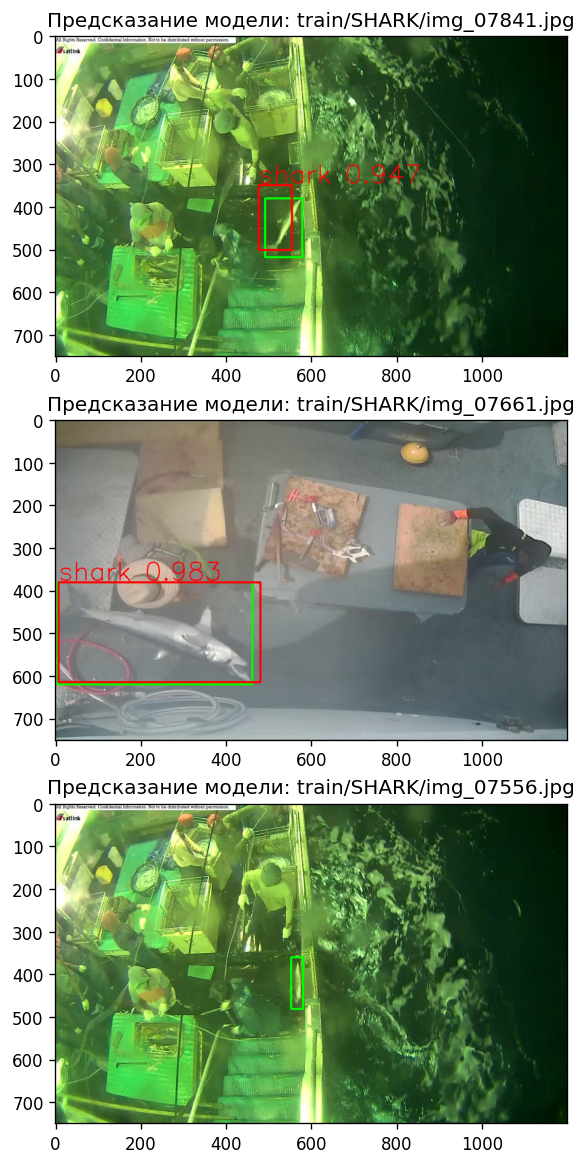

In [16]:
show_detect_res(boxes['shark'][2:5], model)

ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT

0.996, 0.001, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0

 
0.898, 0.019, 0.002, 0.009, 0.004, 0.063, 0.003, 0.002

 
0.999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

 


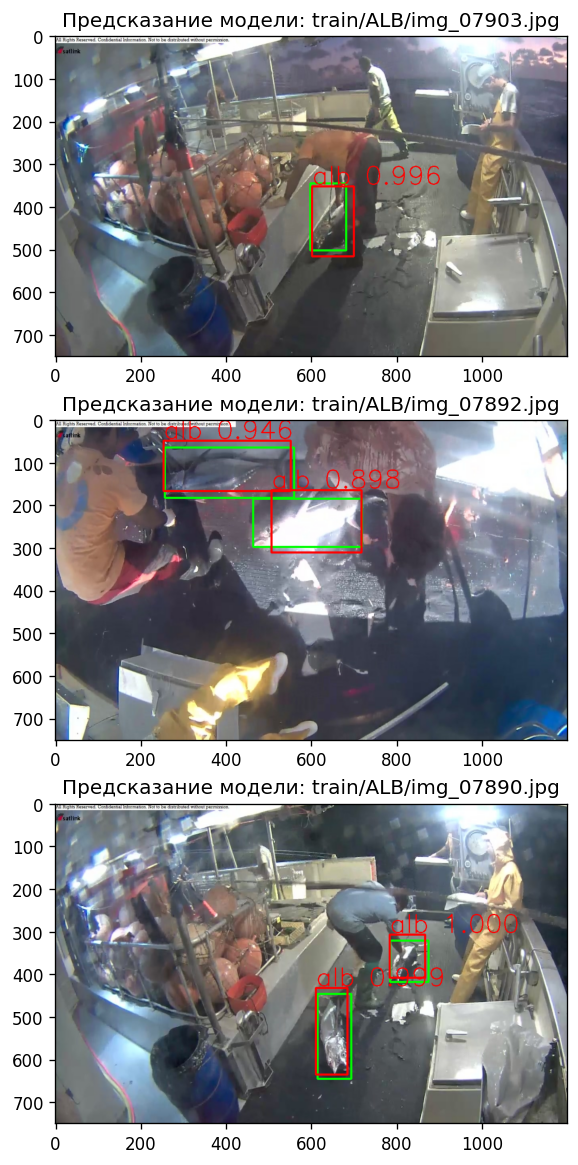

In [17]:
show_detect_res(boxes['alb'][5:8], model)

ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT

0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

 
0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

 


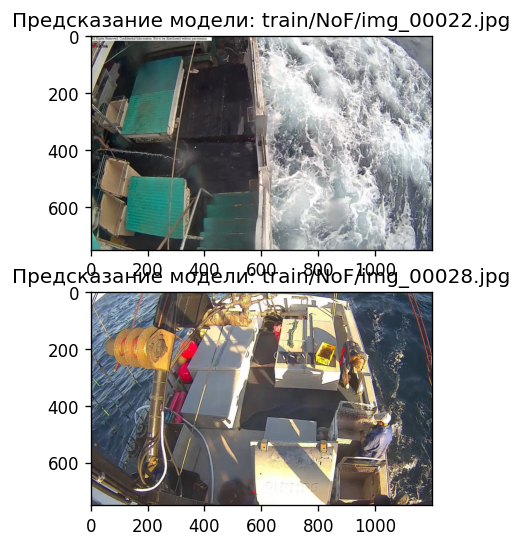

In [18]:
show_detect_res(boxes['nof'][2:4], model)

In [19]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Data_new/My_model_1.hdf5')

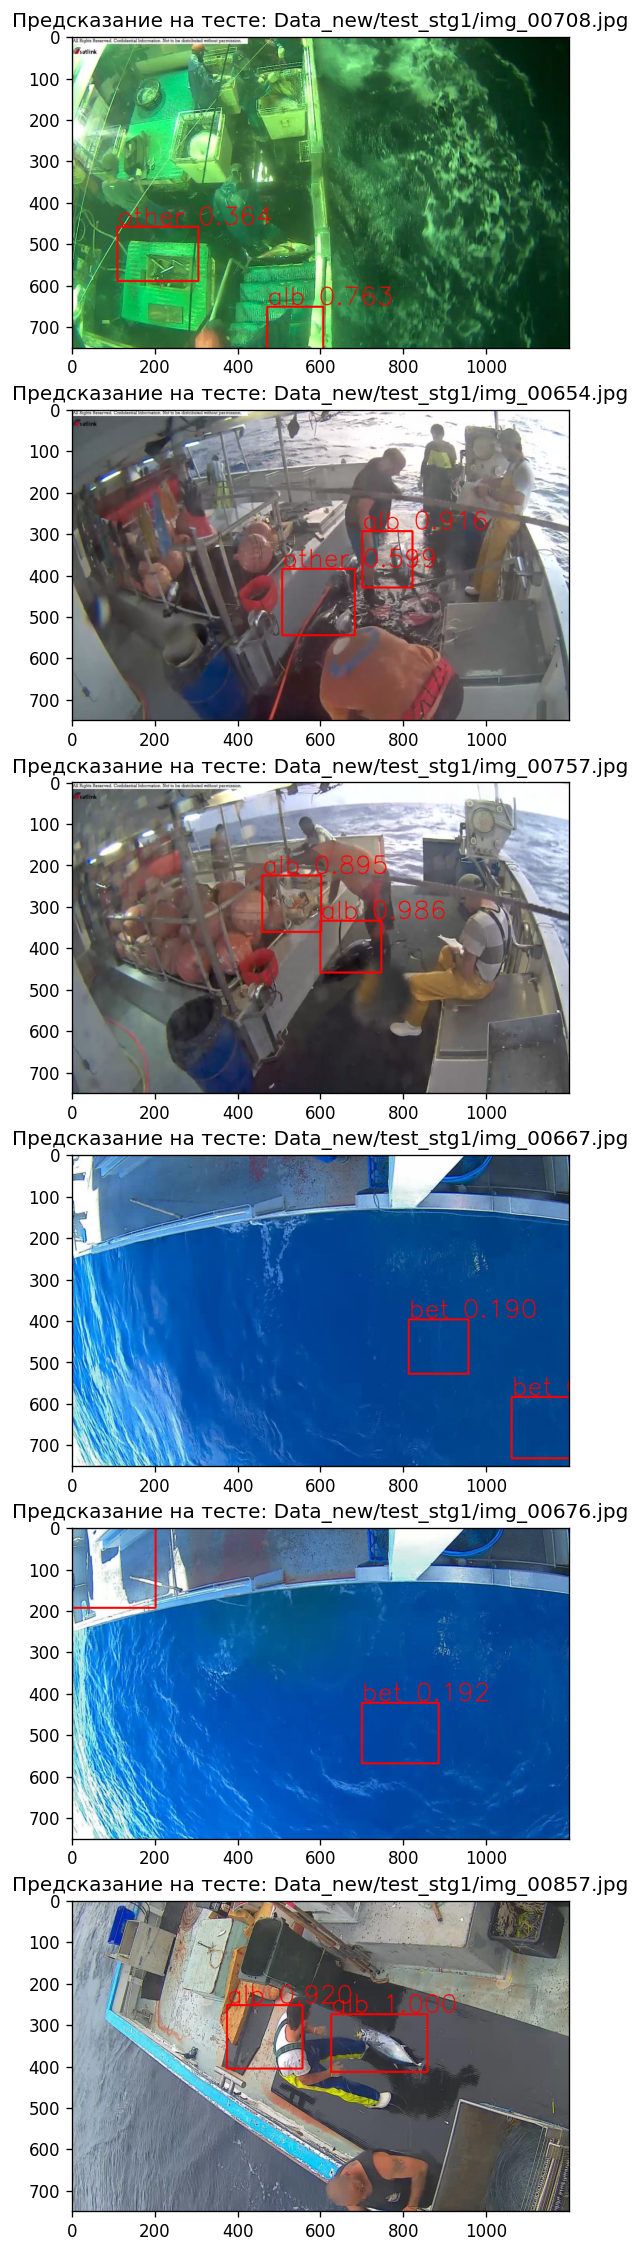

In [20]:
test_images = glob('/content/drive/MyDrive/Colab Notebooks/Data_new/test_stg1/*.jpg')[100:106]



plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.02)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)

    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.subplot(len(test_images), 1, i + 1)
    plt.imshow(img)
    plt.title('Предсказание на тесте: {}'.format('/'.join(filename.split('/')[-3:])))
plt.show()

In [21]:
def load_test_images(TEST_PREFIX):
    images = []
    for path in glob(os.path.join(TEST_PREFIX, '*.jpg')):
        images.append(path)
    return images

test_images1 = sorted(load_test_images('/content/drive/MyDrive/Colab Notebooks/Data_new/test_stg1'))
test_images2 = sorted(load_test_images('/content/drive/MyDrive/Colab Notebooks/Data_new/test_stg2'))

In [24]:
print(len(test_images1))
print(len(test_images2))

1000
12154


In [23]:
%%time

with open('/content/drive/MyDrive/Colab Notebooks/Data_new/submition.csv', 'w') as f:
    f.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
    for filename in test_images1:
      _, sample_img = load_img(filename)
      file_name = filename.split('/')[-1:]
      pred = model.predict(np.array([sample_img,]))

      decoded = decode_prediction(pred[0], conf_thr=0.1)
      decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
      if len(decoded) == 0:
        f.write(f"{''.join(file_name)}, {','.join(str_nof)}\n")
      else:
        f.write(f"{''.join(file_name)}, {str(list(decoded[0]['cls']))[1:-1]}\n")

    for filename in test_images2:
      _, sample_img = load_img(filename)
      file_name = '/'.join(filename.split('/')[-2:])
      pred = model.predict(np.array([sample_img,]))

      decoded = decode_prediction(pred[0], conf_thr=0.1)
      decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
      if len(decoded) == 0:
        f.write(f"{''.join(file_name)}, {','.join(str_nof)}\n")
      else:
        f.write(f"{''.join(file_name)}, {str(list(decoded[0]['cls']))[1:-1]}\n")

CPU times: user 1h 5min 42s, sys: 39min 58s, total: 1h 45min 40s
Wall time: 3h 27s


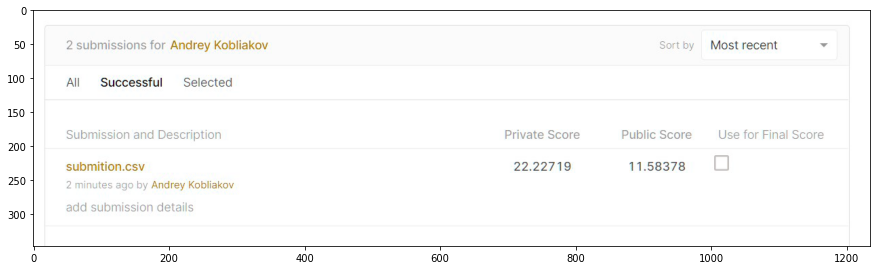

In [27]:
from skimage import io
img_cv = io.imread('/content/drive/MyDrive/Colab Notebooks/Data_new/Kav_submission_1.jpg')
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img_rgb)